In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix


In [2]:
# Read your dataset (replace 'marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv' with your dataset path)
data = pd.read_csv(r'C:\Users\VAGDEVI\Downloads\marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data (2).tsv', sep='\t')
data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [3]:
data = data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
data.head()

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,NaN,NaN,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,0990cf89a59ca6a0460349a3e4f51d42,ce3d761e57d6ccad80619297b5b1bcbc,NaN,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


In [4]:

data['Product Tags']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Product Tags, Length: 5000, dtype: object

In [5]:

data.shape

(5000, 10)

In [6]:
data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [7]:
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
data['Product Rating'].fillna(0, inplace=True)
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
data['Product Reviews Count'].fillna(0, inplace=True)
# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
data['Product Category'].fillna('', inplace=True)
# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
data['Product Brand'].fillna('', inplace=True)
# Fill missing values in 'Product Description' with an empty string
data['Product Description'].fillna('', inplace=True)

In [8]:
data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [9]:

data.duplicated().sum()

0

In [10]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
data.rename(columns=column_name_mapping, inplace=True)

In [11]:
# Basic statistics
num_users = data['ID'].nunique()
num_items = data['ProdID'].nunique()
num_ratings = data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 5000
Number of unique items: 4802
Number of unique ratings: 36


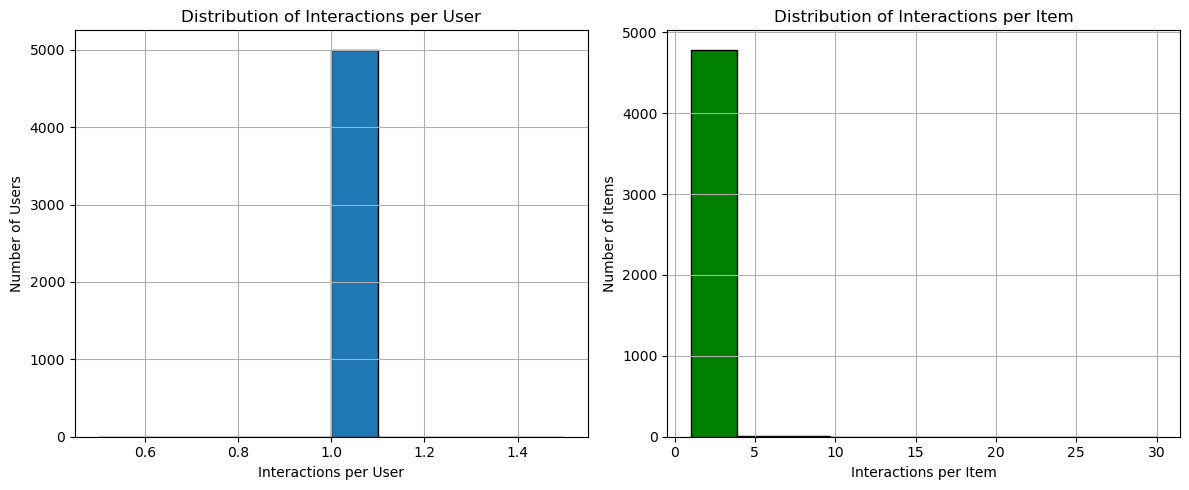

In [12]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

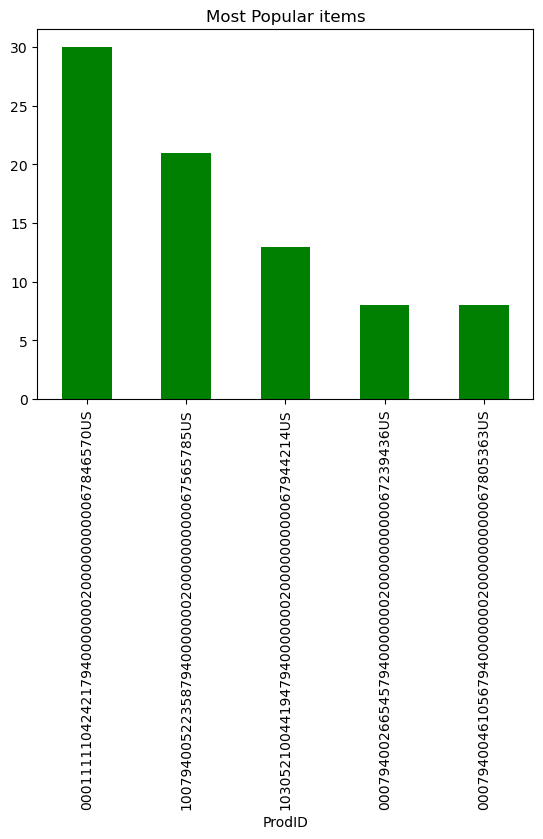

In [13]:
# Most popular items
popular_items = data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='green')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

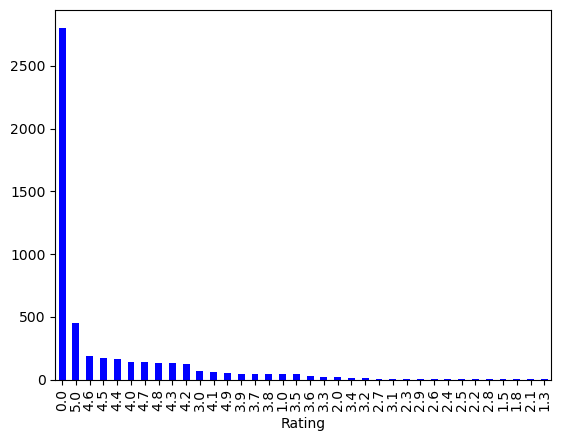

In [14]:
# most rated counts
data['Rating'].value_counts().plot(kind='bar',color='blue')

In [15]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    data[column] = data[column].apply(clean_and_extract_tags)

In [16]:
# Concatenate the cleaned tags from all relevant columns
data['Tags'] = data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

In [17]:
data

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...","beauty, hair, care, hair, color, permanent, ha..."
3,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,0.0,0.0,"beauty, makeup, lip","kokie, cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"calling, matte, lip, lovers, indulge, rich, cr...","beauty, makeup, lip, kokie, cosmetics, calling..."
4,0990cf89a59ca6a0460349a3e4f51d42,ce3d761e57d6ccad80619297b5b1bcbc,0.0,131.0,"seasonal, stock, essentials, personal, care, s...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"1971, gillette, introduced, trac, ii, razor, s...","seasonal, stock, essentials, personal, care, s..."
...,...,...,...,...,...,...,...,...,...,...
4995,2771f0606e9638de508741f52029d51c,ad208aa8da338e84dfcf13efd49e8a75,4.5,2.0,"household, essentials, air, fresheners, spray,...","eclectic, lady","Garden Mint Room Spray (Double Strength), 4 ou...",https://i5.walmartimages.com/asr/0e0416ae-6b70...,"garden, mint, lovely, blend, spearmint, lettuc...","household, essentials, air, fresheners, spray,..."
4996,0f218eb3ac736975ccfdde987baa4b83,1be8241fd6249f7ee007b06afd7ff45d,3.9,7484.0,"beauty, hair, care, hair, color, permanent, ha...",garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,https://i5.walmartimages.com/asr/24d7a837-51f8...,"garnier, nutrisse, nourishing, hair, color, cr...","beauty, hair, care, hair, color, permanent, ha..."
4997,34d1aa70845416c3df059a088aaf18dc,96ed378fb9466b11abde8f9baea58844,0.0,4.0,"beauty, makeup, nails",stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",https://i5.walmartimages.com/asr/d6202179-2c93...,"multifunctional, nail, drill, kit, come, 6, di...","beauty, makeup, nails, stoneway, multifunction..."
4998,ff9cfa22550bf036e2487a9100d927f1,f7b05869f3ee7fe22864ea58cbb006d1,0.0,0.0,"premium, beauty, premium, bath, body, premium,...",creed,Creed Love In Black Hair And Body Wash 6.8oz/2...,https://i5.walmartimages.com/asr/3dc99239-66d2...,,"premium, beauty, premium, bath, body, premium,..."


In [18]:
data.to_csv('whole_data.csv', index=False)


# Content based filtering


In [25]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [28]:
# Fill NaNs in all relevant columns
data['Tags'] = data['Tags'].fillna('')
data['Description'] = data['Description'].fillna('')
data['Brand'] = data['Brand'].fillna('')

In [29]:
# Combine features for better context
data['combined_features'] = data['Tags'] + ' ' + data['Description'] + ' ' + data['Brand'].astype(str)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(data['Description'].fillna(""))

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray())

# Add ProdID as a separate column
tfidf_df['ProdID'] = df['ProdID'].values

# Save properly
tfidf_df.to_csv('data/content_features.csv', index=False)


In [30]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['combined_features'])

In [31]:
# Compute similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [38]:
# Recommendation function
def get_content_recommendations(product_id, top_n=5):
    idx = data[data['ProdID'] == product_id].index
    if len(idx) == 0:
        return "Product ID not found 😢"
    idx = idx[0]
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Skip the first (same product)

    product_indices = [i[0] for i in sim_scores]
    return data.iloc[product_indices][['ProdID', 'Name', 'Brand']]

In [39]:
get_content_recommendations("2e17bf4acecdece67fc00f07ad62c910")

,ProdID,Name,Brand
156,ef58f2d68cfb30f4f72847441706f014,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,opi
184,2b3c8a5059cdefc921a9d85443beb4e2,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,opi
205,fe7a2fff6ced03701471f9f5db2ee22b,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,opi
237,ee4103d60073a9e63134f87806504ea6,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,opi
325,c4eedc9254ec8c73cebcd7a67fd0cdc3,OPI Gel Polish Fall 2019 Scotland Collection G...,opi


# Collaborative Filtering

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import random

In [44]:
# Simulate user IDs if not available
num_users = 50  # or however many you'd like to simulate
user_ids = [f"user_{i}" for i in range(num_users)]

ratings_data = []

for user in user_ids:
    for idx, row in data.iterrows():
        prod_id = row['ProdID']
        rating = row['Rating']

        # If rating is 0 or missing, replace with random float between 2.5 and 5.0
        if pd.isna(rating) or rating == 0:
            rating = round(random.uniform(2.5, 5.0), 1)

        ratings_data.append([user, prod_id, rating])

# Create DataFrame
ratings_df = pd.DataFrame(ratings_data, columns=["UserID", "ProdID", "Rating"])

# Save to CSV
ratings_df.to_csv("data/ratings.csv", index=False)
print("🎉 ratings.csv saved successfully!")


🎉 ratings.csv saved successfully!


In [48]:
# Simulate user-item interaction matrix
# Example: 5 users x n products (random interactions)
user_item_matrix = pd.DataFrame(np.random.randint(0, 2, size=(5, len(data))), 
                                columns=data['ProdID'].values, 
                                index=[f'User{i}' for i in range(1, 6)])

In [49]:
# Transpose for item-item similarity
item_sim_matrix = cosine_similarity(user_item_matrix.T)
item_sim_df = pd.DataFrame(item_sim_matrix, index=user_item_matrix.columns, columns=user_item_matrix.columns)


In [53]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Step 1: Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # ✅ Step 2: Check if target user exists
    if target_user_id not in user_item_matrix.index:
        print(f"User ID {target_user_id} not found in data.")
        print("Available user IDs:", list(user_item_matrix.index))
        return pd.DataFrame()  # Return empty DataFrame

    # Step 3: Calculate cosine similarity between users
    user_similarity = cosine_similarity(user_item_matrix)

    # Step 4: Get index of the target user
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Step 5: Get similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Step 6: Sort similar users (excluding the target user themself)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Step 7: Generate recommendations from similar users
    recommended_items = []

    for user_index in similar_users_indices:
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user > 0) & (user_item_matrix.iloc[target_user_index] == 0)

        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

        if len(recommended_items) >= top_n:
            break

    # Step 8: Fetch item details for recommendations
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL']]

    return recommended_items_details.drop_duplicates().head(top_n)


In [55]:
# Example usage
target_user_id = "0016a804b91dc7940315e093673d0c76"
top_n = 5
recommendations = collaborative_filtering_recommendations(data, target_user_id, top_n)
display(recommendations)


,Name,ReviewCount,Brand,ImageURL
332,"Hard Candy Single & Loving it Eye Shadow, Brn ...",6.0,"hard, candy",https://i5.walmartimages.com/asr/08146799-9538...
1667,"e.l.f. Day to Night Lipstick Duo, Need It Nudes",271.0,cosmetics,https://i5.walmartimages.com/asr/9c17d9b0-35da...
2140,V76 by Vaughn Brightening Conditioner For Silv...,10.0,"v76, vaughn",https://i5.walmartimages.com/asr/611ac2d0-39ef...
2292,"Softsoap Moisturizing Body Wash, Luminous Oils...",448.0,softsoap,https://i5.walmartimages.com/asr/a1d1536f-15d3...
4202,Redken-Diamond Oil Glow Dry Detangling Conditi...,334.0,redken,https://i5.walmartimages.com/asr/f200009c-1f8f...


Index([2.0, 76.0, 8.0, 3.0, 3.0], dtype='float64')
<class 'numpy.float64'>
